# Basins

This tutorial demonstrates using PyWBT to delineate basins for a watershed in London. We use NASADEM to download the DEM data and delineate the basins using PyWBT.

In [1]:
from __future__ import annotations

import shutil
import tempfile
from pathlib import Path

import rioxarray
import utils

from pywbt import whitebox_tools

We use Microsoft Planetary Computer to access the [NASADEM](https://planetarycomputer.microsoft.com/dataset/nasadem) data. For this purpose, we need `planetary_computer` and `pystac_client` package. You can install them using `pip install planetary_computer pystac_client`.

There is a `utils` module that contains utiltiy functions for PyWBT tutorials. You can download it from [here](https://raw.githubusercontent.com/cheginit/pywbt/main/docs/examples/utils.py)

In [2]:
fname = Path("dem.tif")
if not fname.exists():
    bbox = (0.0337, 51.5477, 0.1154, 51.6155)
    utils.get_nasadem(bbox, fname, to_utm=True)

For working with PyWBT, you need give the sequence of the WBT tools that you want to invoke with their respective parameters. In this example, we use the following sequence of tools:

1. `BreachDepressions`: An alternative to filling depressions in a DEM. This tool modifies the DEM to remove all depressions and flat areas, allowing water to flow off the edge of the DEM.
2. `D8Pointer`: A tool for generating flow pointer grid using the simple D8 algorithm.
3. `D8FlowAccumulation`: A tool for computing flow accumulation grid using the D8 algorithm.
4. `ExtractStreams`: A tool for extracting stream channels from a flow accumulation grid.
5. `FindMainStem`: A tool for finding the main stem of a stream network.
6. `StrahlerStreamOrder`: A tool for computing the Strahler stream order of a stream network.
7. `Basins`: A tool for automatic delineation of basins from a flow accumulation grid.

Considering that WBT is a command-line tool, it can generate intermediate files. A good practice for sing PyWBT is to use Python's built-in `tempfile` module to create temporary directory that gets deleted after the execution of the tools and only store the files that are necessary for further analysis. In this example, we need want to store the Strahler stream order and the basins.

In [3]:
with tempfile.TemporaryDirectory(dir=".") as work_dir:
    shutil.copy(fname, work_dir)
    wbt_args = {
        "BreachDepressions": [f"-i={fname}", "--fill_pits", "-o=dem_corr.tif"],
        "D8Pointer": ["-i=dem_corr.tif", "-o=fdir.tif"],
        "D8FlowAccumulation": ["-i=fdir.tif", "--pntr", "-o=d8accum.tif"],
        "ExtractStreams": ["--flow_accum=d8accum.tif", "--threshold=600.0", "-o=streams.tif"],
        "FindMainStem": ["--d8_pntr=fdir.tif", "--streams=d8accum.tif", "-o=mainstem.tif"],
        "StrahlerStreamOrder": ["--d8_pntr=fdir.tif", "--streams=streams.tif", "-o=strahler.tif"],
        "Basins": ["--d8_pntr=fdir.tif", "-o=basins.tif"],
    }
    whitebox_tools(wbt_args, work_dir=work_dir)
    for name in ("strahler", "basins"):
        shutil.copy(Path(work_dir) / f"{name}.tif", f"{name}.tif")

We can take a look at the Strahler stream order and the basins delineated for the watershed.

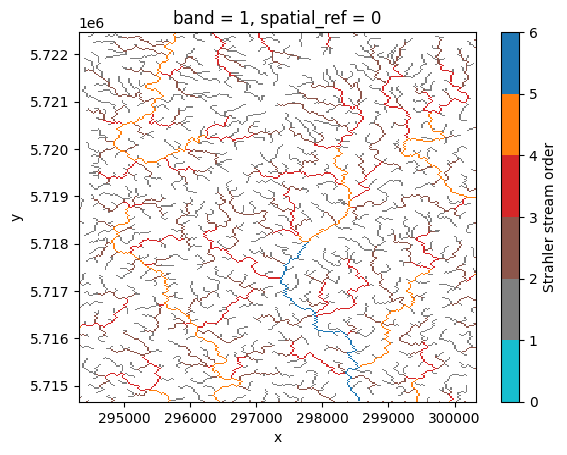

In [4]:
stream_order = rioxarray.open_rasterio("strahler.tif").squeeze()
stream_order = stream_order.astype("uint8")
stream_order.attrs["name"] = "strahler"
stream_order.attrs["long_name"] = "Strahler stream order"
levels = range(stream_order.max().item() + 1)
ax = stream_order.where(stream_order > 0).plot.imshow(robust=False, levels=levels, cmap="tab10_r")
ax.figure.savefig("stream_order.png")

In [5]:
basin_geo = utils.tiff_to_gdf("basins.tif", "int32", "basin")
basin_geo.loc[[basin_geo.area.idxmax()]].explore()